In [1]:
!pip install tensorflow

# Numpy

In [2]:
import numpy as np
np.random.seed(42)
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import datasets

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


### Load dataset from train file and start analisys

## Have to start to define functions that will be called for test dataset too, because train and test must have the same transformations

In [3]:
def t_read(filename):
    # Open file for reading...
    df = pd.read_csv(filename)
    # delete duplicated rows: no more informations
    df.drop_duplicates(keep=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

train = t_read('train.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Winner          25162 non-null  int64
 1   First_pokemon   25162 non-null  int64
 2   Second_pokemon  25162 non-null  int64
dtypes: int64(3)
memory usage: 589.9 KB


In [5]:
# Describe numeric columns
train.describe()

,Winner,First_pokemon,Second_pokemon
count,25162.000000,25162.000000,25162.000000
mean,410.319728,401.578253,403.614419
std,231.039499,230.103952,229.498503
min,1.000000,1.000000,1.000000
25%,209.000000,202.000000,208.000000
50%,423.000000,401.000000,403.000000
75%,607.000000,599.000000,602.000000
max,800.000000,800.000000,800.000000


In [6]:
pokemon = t_read('pokemon.csv')
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [7]:
# Pokemon that don't have a second attack use always the first
pokemon['Type 2'].fillna(pokemon['Type 1'], inplace=True)
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


## Clean attributes
### Delete rows with missing values

In [8]:
# define a function to reuse for test dataset
def t001(train):
    print("Check for missing values: in case (simply) delete the corresponding rows...")
    for i in train.columns:
        n_missing = train[i].isna().sum()
        print(n_missing, "<=", i )
        if (n_missing>0):
            # Assuming n_missing << len(train) then delete rows with blank strings
            train = train[train[i].isna() == False]
    train.reset_index(drop=True, inplace=True)
    return train

train = t001(train)

Check for missing values: in case (simply) delete the corresponding rows...
0 <= Winner
0 <= First_pokemon
0 <= Second_pokemon


In [9]:
# define a function to reuse for test dataset
def t002(train):
    print("Check for empty or blank strings: in case (simply) delete the corresponding rows...")
    # using is_numeric_dtype() from https://stackoverflow.com/a/45568211
    for i in train.columns:
        if not is_numeric_dtype(train[i]):
            n_empty_or_blank = (train[i].str.strip() == '').sum()
            print(n_empty_or_blank, "<=", i )
            if (n_empty_or_blank>0):
                # Assuming n_empty_or_blank << len(train) then delete rows with blank strings
                train = train[train[i].str.strip() != '']
    train.reset_index(drop=True, inplace=True)
    return train

train = t002(train)

Check for empty or blank strings: in case (simply) delete the corresponding rows...


In [10]:
# print remaining rows
len(train)

25162

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Winner          25162 non-null  int64
 1   First_pokemon   25162 non-null  int64
 2   Second_pokemon  25162 non-null  int64
dtypes: int64(3)
memory usage: 589.9 KB


In [12]:
train.describe()

,Winner,First_pokemon,Second_pokemon
count,25162.000000,25162.000000,25162.000000
mean,410.319728,401.578253,403.614419
std,231.039499,230.103952,229.498503
min,1.000000,1.000000,1.000000
25%,209.000000,202.000000,208.000000
50%,423.000000,401.000000,403.000000
75%,607.000000,599.000000,602.000000
max,800.000000,800.000000,800.000000


In [13]:
train.shape

(25162, 3)

In [14]:
# print number and the unique values for each attribute (column of pokemon)
for i in pokemon.columns:
    u = np.sort(pokemon[i].unique().tolist())
    print("Unique on", i,":", len(u), u) 

Unique on # : 800 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 

In [15]:
# print numerosity of unique values, if the unique values<=18 for each attribute (column of pokemon)
def print_numerosity(pokemon):
    for i in pokemon.columns:
        uarr = pokemon[i].unique()
        if len(uarr)<=18:
            uarr.sort()
            print("On", i,":")
            for u in range(len(uarr)):
                print(uarr[u], "#", len(pokemon[pokemon[i] == uarr[u]]))

print_numerosity(pokemon)

On Type 1 :
Bug # 69
Dark # 31
Dragon # 32
Electric # 44
Fairy # 17
Fighting # 27
Fire # 52
Flying # 4
Ghost # 32
Grass # 70
Ground # 32
Ice # 24
Normal # 98
Poison # 28
Psychic # 57
Rock # 44
Steel # 27
Water # 112
On Type 2 :
Bug # 20
Dark # 30
Dragon # 29
Electric # 33
Fairy # 38
Fighting # 46
Fire # 40
Flying # 99
Ghost # 24
Grass # 58
Ground # 48
Ice # 27
Normal # 65
Poison # 49
Psychic # 71
Rock # 23
Steel # 27
Water # 73
On Generation :
1 # 166
2 # 106
3 # 160
4 # 121
5 # 165
6 # 82
On Legendary :
False # 735
True # 65


In [16]:
# Drop 'Name' column: no info, because one for each pokemon
if 'Name' in pokemon.columns:
    pokemon.drop(['Name'], axis=1, inplace=True)
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Type 1      800 non-null    object
 2   Type 2      800 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(2)
memory usage: 63.4+ KB


In [17]:
pokemon.shape

(800, 11)

<AxesSubplot:ylabel='count'>

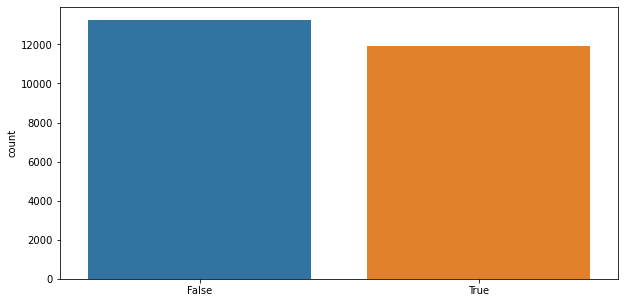

In [18]:
# Set the width and height of the figure
plt.figure(figsize=(10,5))
sns.countplot(x=train['Winner']==train['First_pokemon'])

### No evidence for first or second that win

## In order to evaluate heatmap, apply some transformations to the dataset

In [19]:
# transform_dataset, define a function to reuse for test dataset
def t003(train):
    # add a column that is 0 if first won, or 1 if second won
    train['yWin']=np.where(train["Winner"] == train["First_pokemon"],0,1)

    return train

train = t003(train) # transform_dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Winner          25162 non-null  int64
 1   First_pokemon   25162 non-null  int64
 2   Second_pokemon  25162 non-null  int64
 3   yWin            25162 non-null  int32
dtypes: int32(1), int64(3)
memory usage: 688.1 KB


In [20]:
pokemon.describe()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [21]:
# Check for outliers, over 3 sigma
for i in pokemon.columns:
    if is_numeric_dtype(pokemon[i]):
        l = len(pokemon[((pokemon[i] - pokemon[i].mean()) / pokemon[i].std()).abs() > 3])
        if (l>0):
            print("#Outliers on", i,":", l)

#Outliers on HP : 10
#Outliers on Attack : 5
#Outliers on Defense : 10
#Outliers on Sp. Atk : 5
#Outliers on Sp. Def : 4
#Outliers on Speed : 2
#Outliers on Legendary : 65


In [22]:
# convert the two Type into numbers (just for now to simplify analisys, before Neural must be OHE converted, if still exists)
def convert_category_to_num(df, column, values):
    d = { values[i] : i for i in range(0, len(values) ) }
    # Convert from character to numbers
    df[column] = df[column].map(d)

uval1 = pokemon['Type 1'].unique()
uval1.sort()
uval2 = pokemon['Type 2'].unique()
uval2.sort()
print(uval1, uval2)
if np.array_equal(uval1, uval2):
    convert_category_to_num(pokemon, 'Type 1', uval1)
    convert_category_to_num(pokemon, 'Type 2', uval2)
pokemon.info()

['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water'] ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   #           800 non-null    int64
 1   Type 1      800 non-null    int64
 2   Type 2      800 non-null    int64
 3   HP          800 non-null    int64
 4   Attack      800 non-null    int64
 5   Defense     800 non-null    int64
 6   Sp. Atk     800 non-null    int64
 7   Sp. Def     800 non-null    int64
 8   Speed       800 non-null    int64
 9   Generation  800 non-null    int64
 10  Legendary   800 non-null    bool 
dtypes: bool(1), int64(10)
memory usage: 63.4 KB


In [23]:
pokemon.head()

,#,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,9,13,45,49,49,65,65,45,1,False
1,2,9,13,60,62,63,80,80,60,1,False
2,3,9,13,80,82,83,100,100,80,1,False
3,4,9,13,80,100,123,122,120,80,1,False
4,5,6,6,39,52,43,60,50,65,1,False


## It's time to merge train and pokemon: to have only one dataset
### The new dataset (named train) have the yWin as the target feature. The First_pokemon and Second_pokemon from original train, are used to lookup into pokemon Dataframe and imports the respective data into new dataset. On merging the two group of columns, each column are respectively suffixed with '_1st' and '_2nd'... And then are introduced new columns formed by the difference between first and second values, for all the new columns apart Types (1 and 2), Generation and Legendary (because are categorical).
### The no more useful columns are dropped away (as soon as possible).

In [24]:
def t004(train):
    # Merge train using it's 'First_pokemon' column as join index for pokemon data
    train = pd.merge(train, pokemon,
                     left_on='First_pokemon',
                     right_on='#',
                     how='left')
    # Merge train using it's 'Second_pokemon' column as join index for pokemon data
    # This time there are duplicate column names, which are taken into consideration with suffixes=...
    train = pd.merge(train, pokemon,
                     left_on='Second_pokemon',
                     right_on='#',
                     how='left',
                     suffixes=('_1st', '_2nd'))

    train.drop(['Winner', # yWin is the target feature
                'First_pokemon',  # No more useful
                'Second_pokemon', # No more useful
                '#_1st', # Not used
                '#_2nd'  # Not used
               ], axis = 1, inplace=True)
    return train

train=t004(train)

In [25]:
# Define a function that creates a new column with the calculated difference of the columns which are then dropped
def t_set_diff(df, diff, first, second):
    df[diff] = df[first]-df[second]
    df.drop([first, second], axis = 1, inplace=True)
    return df

In [26]:
def t005(train):
    train = t_set_diff(train, 'HP_', 'HP_1st', 'HP_2nd')
    train = t_set_diff(train, 'Attack_', 'Attack_1st', 'Attack_2nd')
    train = t_set_diff(train, 'Defense_', 'Defense_1st', 'Defense_2nd')
    train = t_set_diff(train, 'Sp. Atk_', 'Sp. Atk_1st', 'Sp. Atk_2nd')
    train = t_set_diff(train, 'Sp. Def_', 'Sp. Def_1st', 'Sp. Def_2nd')
    train = t_set_diff(train, 'Speed_', 'Speed_1st', 'Speed_2nd')
    return train

train = t005(train)
train.head()

,yWin,Type 1_1st,Type 2_1st,Generation_1st,Legendary_1st,Type 1_2nd,Type 2_2nd,Generation_2nd,Legendary_2nd,HP_,Attack_,Defense_,Sp. Atk_,Sp. Def_,Speed_
0,1,10,7,5,True,1,6,2,False,14,55,40,-5,0,-4
1,1,4,4,2,False,16,14,3,False,-5,-35,-15,5,5,-10
2,1,12,9,5,False,11,11,5,False,-11,-35,-35,-70,-45,-4
3,0,17,17,4,False,0,0,5,False,50,60,15,60,35,75
4,0,17,17,3,True,17,17,1,False,50,48,42,85,90,35


<AxesSubplot:xlabel='Speed_', ylabel='count'>

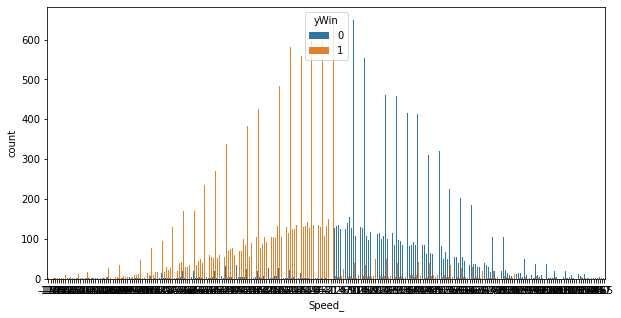

In [27]:
# Set the width and height of the figure
plt.figure(figsize=(10,5))
sns.countplot(x=train['Speed_'], hue=train['yWin'])

<Figure size 1152x720 with 0 Axes>

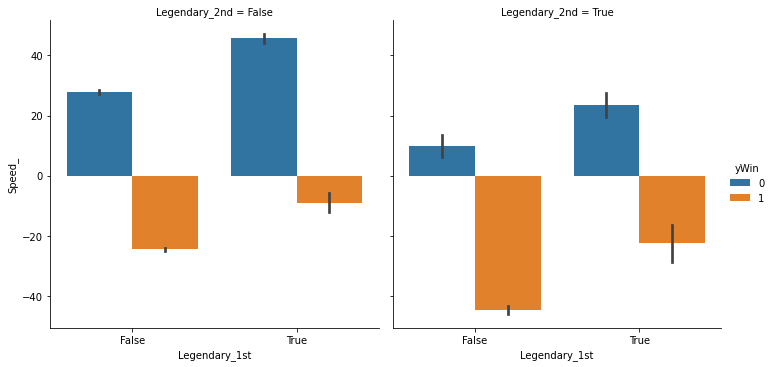

In [28]:
plt.figure(figsize=(16,10))
sns.catplot(y="Speed_", x="Legendary_1st", col="Legendary_2nd", hue="yWin", data=train, kind="bar")

### Faster speed increases the chances of victory...
### If one pokemon is Legendary and the other is not Legendary then the chances of victory is high.

In [29]:
# define a function to reuse for test dataset
def t006(train):
    # Create 'Legendary_N_B' column that say if none or both are Legendary pokemon
    train['Legendary_N_B'] = ~(train['Legendary_1st'] ^ train['Legendary_2nd'])
    # Create 'Legendary_First' column that say if only First is Legendary pokemon
    train['Legendary_First'] = (train['Legendary_N_B'] == False) & train['Legendary_1st']
    # Create 'Legendary_Second' column that say if only Second is Legendary pokemon
    train['Legendary_Second'] = (train['Legendary_N_B'] == False) & train['Legendary_2nd']

    train.drop(['Legendary_1st', 'Legendary_2nd'], axis = 1, inplace=True)

    # Transfom True/False values into 0/1
    for i in ['Legendary_N_B', 'Legendary_First', 'Legendary_Second']:
        train[i] = train[i].map({True:1, False:0})

    train.reset_index(drop=True, inplace=True)

    return train

train = t006(train)
len(train)

25162

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   yWin              25162 non-null  int32
 1   Type 1_1st        25162 non-null  int64
 2   Type 2_1st        25162 non-null  int64
 3   Generation_1st    25162 non-null  int64
 4   Type 1_2nd        25162 non-null  int64
 5   Type 2_2nd        25162 non-null  int64
 6   Generation_2nd    25162 non-null  int64
 7   HP_               25162 non-null  int64
 8   Attack_           25162 non-null  int64
 9   Defense_          25162 non-null  int64
 10  Sp. Atk_          25162 non-null  int64
 11  Sp. Def_          25162 non-null  int64
 12  Speed_            25162 non-null  int64
 13  Legendary_N_B     25162 non-null  int64
 14  Legendary_First   25162 non-null  int64
 15  Legendary_Second  25162 non-null  int64
dtypes: int32(1), int64(15)
memory usage: 3.0 MB


In [31]:
train.describe()

,yWin,Type 1_1st,Type 2_1st,Generation_1st,Type 1_2nd,Type 2_2nd,Generation_2nd,HP_,Attack_,Defense_,Sp. Atk_,Sp. Def_,Speed_,Legendary_N_B,Legendary_First,Legendary_Second
count,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000
mean,0.526588,9.527701,9.283841,3.327120,9.500079,9.234838,3.342461,-0.126659,0.180192,0.134568,0.168389,-0.106112,0.031118,0.844885,0.076266,0.078849
std,0.499303,5.591328,4.848300,1.655263,5.590679,4.839449,1.650785,35.638098,46.241994,44.491873,46.678304,39.237956,41.500796,0.362021,0.265428,0.269508
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-225.000000,-170.000000,-200.000000,-174.000000,-200.000000,-170.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,6.000000,2.000000,5.000000,6.000000,2.000000,-20.000000,-30.000000,-26.000000,-30.000000,-25.000000,-29.000000,1.000000,0.000000,0.000000
50%,1.000000,10.000000,9.000000,3.000000,10.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,14.000000,13.000000,5.000000,14.000000,13.000000,5.000000,20.000000,30.000000,27.000000,30.000000,25.000000,29.000000,1.000000,0.000000,0.000000
max,1.000000,17.000000,17.000000,6.000000,17.000000,17.000000,6.000000,225.000000,175.000000,215.000000,179.000000,205.000000,165.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

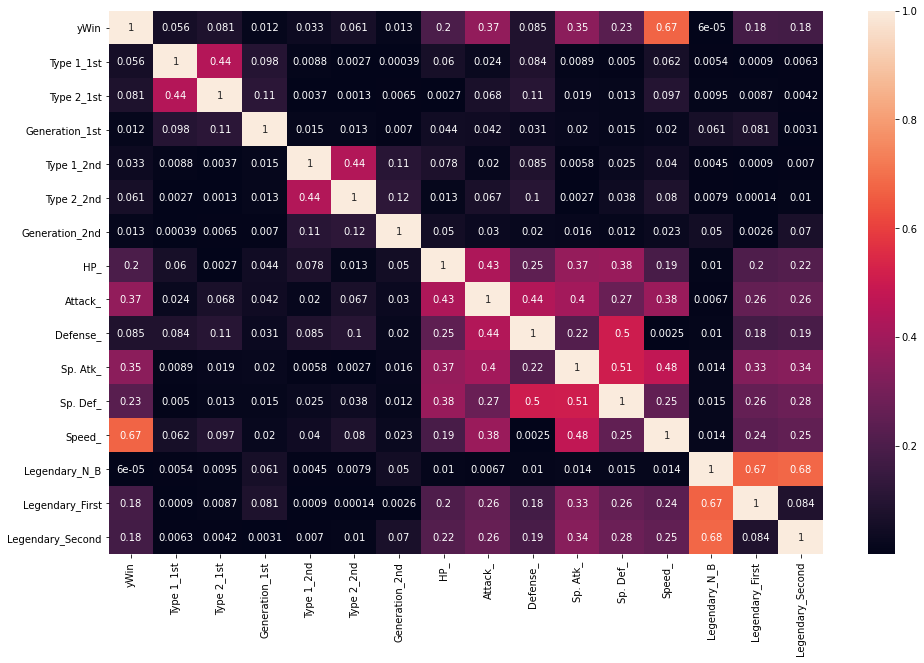

In [32]:
# Set the width and height of the figure
plt.figure(figsize=(16,10))
sns.heatmap(data=train.corr().abs(), annot=True)

In [33]:
# Try to find features that are not related to the target 'yWin'
abs(train.corr()['yWin']).sort_values()[:-1]

Legendary_N_B       0.000060
Generation_1st      0.012039
Generation_2nd      0.012556
Type 1_2nd          0.033203
Type 1_1st          0.056062
Type 2_2nd          0.061410
Type 2_1st          0.080630
Defense_            0.084816
Legendary_Second    0.178170
Legendary_First     0.180990
HP_                 0.196165
Sp. Def_            0.226685
Sp. Atk_            0.350629
Attack_             0.366071
Speed_              0.674421
Name: yWin, dtype: float64

In [34]:
# Define maxcorr() that try to find the attribute that have corr()>=minimum_corr with the maximum number of other attributes,
# so that attributes could be dropped, because their "information" is carried by that attribute.
def maxcorr(train, listcolumn, minimum_corr):
    listcolumn = train.columns
    listsum=[]
    for i in listcolumn:
        sum=0.0
        exclude=[]
        for j in listcolumn:
            # do not take into consideration the same attribute as i (nor target 'yWin')
            if ((i!=j) & (j!='yWin') & (abs(train[i].corr(train[j]))>=minimum_corr)):
                sum += abs(train[i].corr(train[j]))
                exclude.append(j)
        if (sum>0.0):
            listsum.append([sum, i, exclude])
    if len(listsum)>0:
        listsum.sort(reverse=True)
        for s in listsum:
            print(len(s[2]),":",s[0], "sum of corr() of ", s[1])
            print(s[2])
        return listsum[0][2]
    else:
        print("Not found")
        return []

In [35]:
coldrop = maxcorr(train, train.columns, 0.5)

2 : 1.353418033818745 sum of corr() of  Legendary_N_B
['Legendary_First', 'Legendary_Second']
2 : 1.012603850565904 sum of corr() of  Sp. Def_
['Defense_', 'Sp. Atk_']
1 : 0.6828180531274214 sum of corr() of  Legendary_Second
['Legendary_N_B']
1 : 0.6744205962390183 sum of corr() of  yWin
['Speed_']
1 : 0.6705999806913235 sum of corr() of  Legendary_First
['Legendary_N_B']
1 : 0.5083340168375678 sum of corr() of  Sp. Atk_
['Sp. Def_']
1 : 0.5042698337283363 sum of corr() of  Defense_
['Sp. Def_']


## I choose to delete feature that have a (weak) correlation<0.17 with 'yWin'

In [36]:
def t007(train):
    train = train.drop(['Legendary_N_B',
                        'Generation_1st',
                        'Generation_2nd',
                        'Type 1_2nd',
                        'Type 1_1st',
                        'Type 2_2nd',
                        'Type 2_1st',
                        'Defense_'], axis=1)

    return train

train = t007(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   yWin              25162 non-null  int32
 1   HP_               25162 non-null  int64
 2   Attack_           25162 non-null  int64
 3   Sp. Atk_          25162 non-null  int64
 4   Sp. Def_          25162 non-null  int64
 5   Speed_            25162 non-null  int64
 6   Legendary_First   25162 non-null  int64
 7   Legendary_Second  25162 non-null  int64
dtypes: int32(1), int64(7)
memory usage: 1.4 MB


<AxesSubplot:>

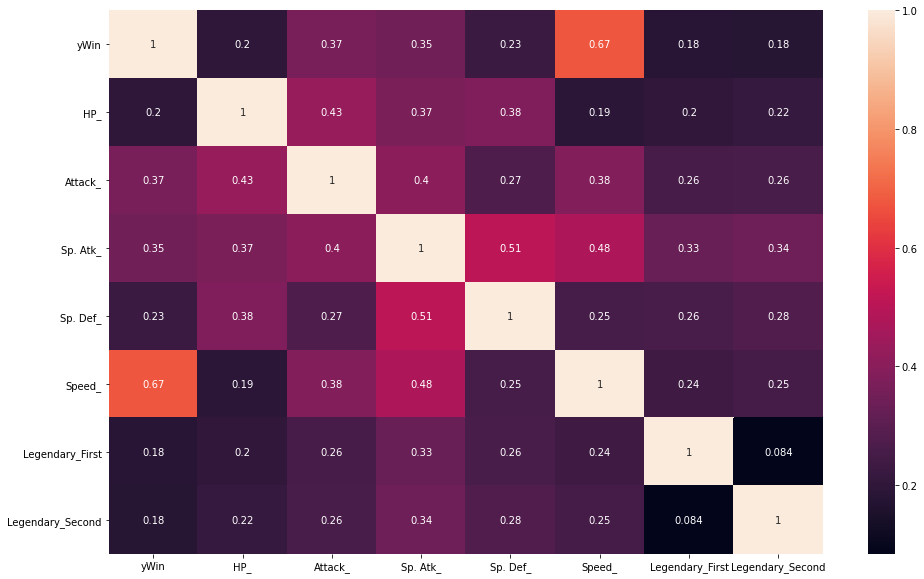

In [37]:
# Set the width and height of the figure
plt.figure(figsize=(16,10))
sns.heatmap(data=train.corr().abs(), annot=True)

In [38]:
maxcorr(train, train.columns, 0.5)

1 : 0.6744205962390183 sum of corr() of  yWin
['Speed_']
1 : 0.5083340168375678 sum of corr() of  Sp. Def_
['Sp. Atk_']
1 : 0.5083340168375678 sum of corr() of  Sp. Atk_
['Sp. Def_']


['Speed_']

## Define a function to convert a column of the dataset into number and then normalize the column

In [39]:
def convert_normalize(df, column):
    dfc = df[column].astype(float)
    # Then normalize the column, subtracting mean and then dividing by std
    # convert to 0 all NaN (in case of some divide by zero...)
    df[column] = ((dfc-dfc.mean(axis=0))/dfc.std(axis=0)).fillna(0)

In [40]:
def convert_normalize_dataset(df):
    convert_normalize(df, "HP_")
    convert_normalize(df, "Attack_")
    convert_normalize(df, "Sp. Atk_")
    convert_normalize(df, "Sp. Def_")
    convert_normalize(df, "Speed_")
    df['target'] = pd.Series(pd.get_dummies(pd.Series(df['yWin'])).to_numpy().tolist())
    df = df.drop(['yWin'], axis=1)
    return df

In [41]:
def transform_accordingly(test):
    test = t001(test)
    test = t002(test)
    test = t003(test)
    test = t004(test)
    test = t005(test)
    test = t006(test)
    test = t007(test)
    return test

In [42]:
train = convert_normalize_dataset(train)

In [43]:
train['target'][0:]

0        [0, 1]
1        [0, 1]
2        [0, 1]
3        [1, 0]
4        [1, 0]
          ...  
25157    [0, 1]
25158    [1, 0]
25159    [1, 0]
25160    [1, 0]
25161    [0, 1]
Name: target, Length: 25162, dtype: object

### Load dataset from test file transform and normalize

In [44]:
# Open the test file for reading...
test = t_read('test.csv')

In [45]:
test = transform_accordingly(test)
test = convert_normalize_dataset(test)

Check for missing values: in case (simply) delete the corresponding rows...
0 <= Winner
0 <= First_pokemon
0 <= Second_pokemon
Check for empty or blank strings: in case (simply) delete the corresponding rows...


### Create X and y train data

In [46]:
y_train = train['target'].to_numpy().tolist()
len(y_train)

25162

In [47]:
X_train = train.drop('target', axis=1).to_numpy()
X_train.shape

(25162, 7)

### Create X and y test data

In [48]:
y_test = test['target'].to_numpy().tolist()
len(y_test)

12394

In [49]:
X_test = test.drop('target', axis=1).to_numpy()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12394 entries, 0 to 12393
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HP_               12394 non-null  float64
 1   Attack_           12394 non-null  float64
 2   Sp. Atk_          12394 non-null  float64
 3   Sp. Def_          12394 non-null  float64
 4   Speed_            12394 non-null  float64
 5   Legendary_First   12394 non-null  int64  
 6   Legendary_Second  12394 non-null  int64  
 7   target            12394 non-null  object 
dtypes: float64(5), int64(2), object(1)
memory usage: 774.8+ KB


In [50]:
# Convert sets because of tensorflow
X_train = tf.convert_to_tensor(X_train, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)

In [71]:
# my_model return model and history.
# if n_epochs is negative then no regolarization
def my_model(X_train, y_train, n_epochs, optimizer):
    # https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = tf.keras.Sequential()

    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    # Add regular densely-connected NN layer, with input size units (X_train.shape[1])
    model.add(tf.keras.layers.Dense(X_train.shape[1], activation=tf.nn.relu ))
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
    # Applies Dropout to the input (of this NN layer) with one fifth rate.
    if (n_epochs>0):
        model.add(tf.keras.layers.Dropout(0.2))

    # Add another regular densely-connected NN layer, with nearly half of input size units
    model.add(tf.keras.layers.Dense(X_train.shape[1]/2, activation=tf.nn.relu ))
    # Applies Dropout to the input (of this NN layer) with one fifth rate.
    if (n_epochs>0):
        model.add(tf.keras.layers.Dropout(0.2))

    #Add last NN layer, with 1 units that represent the single output
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.relu ))

    # Stochastic Gradient Descent as optimizer
    #optimizer = tf.optimizers.SGD(learning_rate=lr)
    # MeanSquaredError as loss function
    loss = tf.losses.MeanSquaredError()

    # Use an early stopping
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

    # Compile model
    if optimizer:

        model.compile(
                      loss=loss,
                      optimizer=optimizer, 
                      metrics=['accuracy'])
    else:
        model.compile(
                      loss=loss,
                      metrics=['accuracy'])

    # fit the model: do the train...
    history = model.fit(X_train, y_train, epochs=abs(n_epochs),
                      use_multiprocessing = True,
                      callbacks=[es])
    
    # from https://stackoverflow.com/a/65288168
    # printout output
    layerIndex = -1
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=layerIndex).output)
    layerOutput = func([X_train.numpy()])  # input_data is a numpy array
    print(layerOutput)
    
    plt.plot(history.history['loss'])

    return model, history

In [52]:
# Learning rate
lr = 0.05

787/787 [==============================] - 1s 717us/step - loss: 0.2814 - accuracy: 0.6797
[[0.40913376 0.5242065 ]
 [0.08959182 0.90674263]
 [0.3033187  0.49676073]
 ...
 [1.0106951  0.10490477]
 [0.9814759  0.        ]
 [0.         1.0722666 ]]


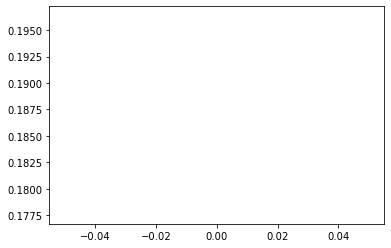

In [72]:
model, history = my_model(X_train, y_train, -1, None )

787/787 [==============================] - 1s 735us/step - loss: 0.4030 - accuracy: 0.4746
[[0.23673812 0.        ]
 [0.15402508 0.        ]
 [0.33466077 0.        ]
 ...
 [0.81898594 0.        ]
 [0.86726886 0.        ]
 [0.         0.        ]]


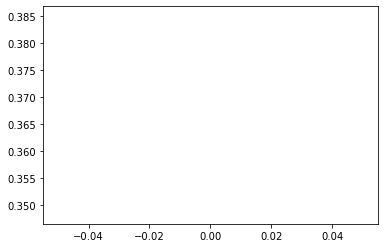

In [73]:
model, history = my_model(X_train, y_train, 1, None)

Epoch 1/10000
13/13 [==============================] - 0s 830us/step - loss: 0.4055 - accuracy: 0.5344
Epoch 2/10000
13/13 [==============================] - 0s 992us/step - loss: 0.3387 - accuracy: 0.5066
Epoch 3/10000
13/13 [==============================] - 0s 869us/step - loss: 0.3328 - accuracy: 0.5145
Epoch 4/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.3190 - accuracy: 0.5053
Epoch 5/10000
13/13 [==============================] - 0s 932us/step - loss: 0.3002 - accuracy: 0.5322
Epoch 6/10000
13/13 [==============================] - 0s 955us/step - loss: 0.2555 - accuracy: 0.6507
Epoch 7/10000
13/13 [==============================] - 0s 743us/step - loss: 0.1844 - accuracy: 0.8014
Epoch 8/10000
13/13 [==============================] - 0s 868us/step - loss: 0.1557 - accuracy: 0.8304
Epoch 9/10000
13/13 [==============================] - 0s 765us/step - loss: 0.1648 - accuracy: 0.7907
Epoch 10/10000
13/13 [==============================] - 0s 897us/step - los

Epoch 80/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0776 - accuracy: 0.9312
Epoch 81/10000
13/13 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.93 - 0s 850us/step - loss: 0.0907 - accuracy: 0.9150
Epoch 82/10000
13/13 [==============================] - 0s 746us/step - loss: 0.0907 - accuracy: 0.9178
Epoch 83/10000
13/13 [==============================] - 0s 854us/step - loss: 0.0937 - accuracy: 0.9154
Epoch 84/10000
13/13 [==============================] - 0s 812us/step - loss: 0.0858 - accuracy: 0.9097
Epoch 85/10000
13/13 [==============================] - 0s 832us/step - loss: 0.0837 - accuracy: 0.9291
Epoch 86/10000
13/13 [==============================] - 0s 772us/step - loss: 0.0837 - accuracy: 0.9340
Epoch 87/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0699 - accuracy: 0.9385
Epoch 88/10000
13/13 [==============================] - 0s 918us/step - loss: 0.0845 - accuracy: 0.9155
Epoch 89/10000
13/13 [

13/13 [==============================] - 0s 838us/step - loss: 0.0591 - accuracy: 0.9374
Epoch 158/10000
13/13 [==============================] - 0s 737us/step - loss: 0.0621 - accuracy: 0.9354
Epoch 159/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0675 - accuracy: 0.9328
Epoch 160/10000
13/13 [==============================] - 0s 998us/step - loss: 0.0649 - accuracy: 0.9344
Epoch 161/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0587 - accuracy: 0.9387
Epoch 162/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0565 - accuracy: 0.9427
Epoch 163/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0608 - accuracy: 0.9424
Epoch 164/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0652 - accuracy: 0.9294
Epoch 165/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0696 - accuracy: 0.9283
Epoch 166/10000
13/13 [==============================] - 0s 831us/step 

13/13 [==============================] - 0s 748us/step - loss: 0.0531 - accuracy: 0.9397
Epoch 236/10000
13/13 [==============================] - 0s 779us/step - loss: 0.0737 - accuracy: 0.9112
Epoch 237/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0607 - accuracy: 0.9325
Epoch 238/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0557 - accuracy: 0.9365
Epoch 239/10000
13/13 [==============================] - 0s 779us/step - loss: 0.0678 - accuracy: 0.9110
Epoch 240/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0608 - accuracy: 0.9262
Epoch 241/10000
13/13 [==============================] - 0s 743us/step - loss: 0.0542 - accuracy: 0.9378
Epoch 242/10000
13/13 [==============================] - 0s 804us/step - loss: 0.0544 - accuracy: 0.9437
Epoch 243/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0625 - accuracy: 0.9272
Epoch 244/10000
13/13 [==============================] - 0s 722us/step 

13/13 [==============================] - 0s 748us/step - loss: 0.0513 - accuracy: 0.9353
Epoch 314/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0481 - accuracy: 0.9525
Epoch 315/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0583 - accuracy: 0.9416
Epoch 316/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0595 - accuracy: 0.9294
Epoch 317/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0534 - accuracy: 0.9344
Epoch 318/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0492 - accuracy: 0.9439
Epoch 319/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0558 - accuracy: 0.9367
Epoch 320/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0445 - accuracy: 0.9514
Epoch 321/10000
13/13 [==============================] - 0s 666us/step - loss: 0.0584 - accuracy: 0.9330
Epoch 322/10000
13/13 [==============================] - 0s 720us/step 

13/13 [==============================] - 0s 915us/step - loss: 0.0460 - accuracy: 0.9489
Epoch 391/10000
13/13 [==============================] - 0s 838us/step - loss: 0.0449 - accuracy: 0.9469
Epoch 392/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0510 - accuracy: 0.9451
Epoch 393/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0490 - accuracy: 0.9462
Epoch 394/10000
13/13 [==============================] - 0s 747us/step - loss: 0.0497 - accuracy: 0.9434
Epoch 395/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0513 - accuracy: 0.9398
Epoch 396/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0540 - accuracy: 0.9421
Epoch 397/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0358 - accuracy: 0.9594
Epoch 398/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0523 - accuracy: 0.9366
Epoch 399/10000
13/13 [==============================] - 0s 665us/step 

13/13 [==============================] - 0s 724us/step - loss: 0.0449 - accuracy: 0.9564
Epoch 469/10000
13/13 [==============================] - 0s 901us/step - loss: 0.0442 - accuracy: 0.9542
Epoch 470/10000
13/13 [==============================] - 0s 985us/step - loss: 0.0393 - accuracy: 0.9582
Epoch 471/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.0429 - accuracy: 0.9476
Epoch 472/10000
13/13 [==============================] - 0s 965us/step - loss: 0.0398 - accuracy: 0.9577
Epoch 473/10000
13/13 [==============================] - 0s 988us/step - loss: 0.0440 - accuracy: 0.9512
Epoch 474/10000
13/13 [==============================] - 0s 909us/step - loss: 0.0432 - accuracy: 0.9550
Epoch 475/10000
13/13 [==============================] - 0s 796us/step - loss: 0.0505 - accuracy: 0.9433
Epoch 476/10000
13/13 [==============================] - 0s 852us/step - loss: 0.0581 - accuracy: 0.9302
Epoch 477/10000
13/13 [==============================] - 0s 912us/step - 

13/13 [==============================] - 0s 776us/step - loss: 0.0396 - accuracy: 0.9643
Epoch 547/10000
13/13 [==============================] - 0s 929us/step - loss: 0.0460 - accuracy: 0.9502
Epoch 548/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.9611
Epoch 549/10000
13/13 [==============================] - 0s 911us/step - loss: 0.0451 - accuracy: 0.9593
Epoch 550/10000
13/13 [==============================] - 0s 912us/step - loss: 0.0422 - accuracy: 0.9529
Epoch 551/10000
13/13 [==============================] - 0s 938us/step - loss: 0.0411 - accuracy: 0.9553
Epoch 552/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0460 - accuracy: 0.9584
Epoch 553/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0410 - accuracy: 0.9597
Epoch 554/10000
13/13 [==============================] - 0s 905us/step - loss: 0.0393 - accuracy: 0.9623
Epoch 555/10000
13/13 [==============================] - 0s 831us/step - 

Epoch 624/10000
13/13 [==============================] - 0s 778us/step - loss: 0.0470 - accuracy: 0.9546
Epoch 625/10000
13/13 [==============================] - 0s 908us/step - loss: 0.0504 - accuracy: 0.9504
Epoch 626/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0462 - accuracy: 0.9516
Epoch 627/10000
13/13 [==============================] - 0s 850us/step - loss: 0.0540 - accuracy: 0.9481
Epoch 628/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0363 - accuracy: 0.9626
Epoch 629/10000
13/13 [==============================] - 0s 953us/step - loss: 0.0342 - accuracy: 0.9601
Epoch 630/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0527 - accuracy: 0.9465
Epoch 631/10000
13/13 [==============================] - 0s 711us/step - loss: 0.0433 - accuracy: 0.9535
Epoch 632/10000
13/13 [==============================] - 0s 834us/step - loss: 0.0536 - accuracy: 0.9495
Epoch 633/10000
13/13 [==============================] 

13/13 [==============================] - 0s 830us/step - loss: 0.0400 - accuracy: 0.9651
Epoch 703/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0356 - accuracy: 0.9649
Epoch 704/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0414 - accuracy: 0.9600
Epoch 705/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0436 - accuracy: 0.9597
Epoch 706/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0474 - accuracy: 0.9542
Epoch 707/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0327 - accuracy: 0.9715
Epoch 708/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0421 - accuracy: 0.9603
Epoch 709/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0440 - accuracy: 0.9479
Epoch 710/10000
13/13 [==============================] - 0s 767us/step - loss: 0.0453 - accuracy: 0.9578
Epoch 711/10000
13/13 [==============================] - 0s 665us/step 

13/13 [==============================] - 0s 748us/step - loss: 0.0455 - accuracy: 0.9601
Epoch 780/10000
13/13 [==============================] - 0s 936us/step - loss: 0.0362 - accuracy: 0.9612
Epoch 781/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0340 - accuracy: 0.9713
Epoch 782/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0361 - accuracy: 0.9641
Epoch 783/10000
13/13 [==============================] - 0s 664us/step - loss: 0.0388 - accuracy: 0.9604
Epoch 784/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0583 - accuracy: 0.9371
Epoch 785/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0343 - accuracy: 0.9699
Epoch 786/10000
13/13 [==============================] - 0s 789us/step - loss: 0.0471 - accuracy: 0.9549
Epoch 787/10000
13/13 [==============================] - 0s 843us/step - loss: 0.0534 - accuracy: 0.9369
Epoch 788/10000
13/13 [==============================] - 0s 831us/step 

13/13 [==============================] - 0s 831us/step - loss: 0.0411 - accuracy: 0.9599
Epoch 857/10000
13/13 [==============================] - 0s 915us/step - loss: 0.0567 - accuracy: 0.9509
Epoch 858/10000
13/13 [==============================] - 0s 915us/step - loss: 0.0434 - accuracy: 0.9549
Epoch 859/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0575 - accuracy: 0.9347
Epoch 860/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0507 - accuracy: 0.9562
Epoch 861/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0363 - accuracy: 0.9607
Epoch 862/10000
13/13 [==============================] - 0s 832us/step - loss: 0.0410 - accuracy: 0.9622
Epoch 863/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0335 - accuracy: 0.9699
Epoch 864/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0443 - accuracy: 0.9548
Epoch 865/10000
13/13 [==============================] - 0s 667us/step 

13/13 [==============================] - 0s 917us/step - loss: 0.0333 - accuracy: 0.9696
Epoch 934/10000
13/13 [==============================] - 0s 834us/step - loss: 0.0390 - accuracy: 0.9638
Epoch 935/10000
13/13 [==============================] - 0s 783us/step - loss: 0.0438 - accuracy: 0.9610
Epoch 936/10000
13/13 [==============================] - 0s 637us/step - loss: 0.0348 - accuracy: 0.9708
Epoch 937/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0416 - accuracy: 0.9617
Epoch 938/10000
13/13 [==============================] - 0s 834us/step - loss: 0.0370 - accuracy: 0.9680
Epoch 939/10000
13/13 [==============================] - 0s 745us/step - loss: 0.0518 - accuracy: 0.9463
Epoch 940/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0478 - accuracy: 0.9542
Epoch 941/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0503 - accuracy: 0.9516
Epoch 942/10000
13/13 [==============================] - 0s 748us/step 

Epoch 1011/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0506 - accuracy: 0.9498
Epoch 1012/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0426 - accuracy: 0.9563
Epoch 1013/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0407 - accuracy: 0.9621
Epoch 1014/10000
13/13 [==============================] - 0s 664us/step - loss: 0.0375 - accuracy: 0.9657
Epoch 1015/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0368 - accuracy: 0.9678
Epoch 1016/10000
13/13 [==============================] - 0s 709us/step - loss: 0.0397 - accuracy: 0.9646
Epoch 1017/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0390 - accuracy: 0.9642
Epoch 1018/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0440 - accuracy: 0.9588
Epoch 1019/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0400 - accuracy: 0.9619
Epoch 1020/10000
13/13 [======================

13/13 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9542
Epoch 1089/10000
13/13 [==============================] - 0s 963us/step - loss: 0.0479 - accuracy: 0.9547
Epoch 1090/10000
13/13 [==============================] - 0s 991us/step - loss: 0.0431 - accuracy: 0.9631
Epoch 1091/10000
13/13 [==============================] - 0s 946us/step - loss: 0.0386 - accuracy: 0.9635
Epoch 1092/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0357 - accuracy: 0.9676
Epoch 1093/10000
13/13 [==============================] - 0s 864us/step - loss: 0.0281 - accuracy: 0.9730
Epoch 1094/10000
13/13 [==============================] - 0s 813us/step - loss: 0.0324 - accuracy: 0.9751
Epoch 1095/10000
13/13 [==============================] - 0s 741us/step - loss: 0.0469 - accuracy: 0.9571
Epoch 1096/10000
13/13 [==============================] - 0s 963us/step - loss: 0.0361 - accuracy: 0.9669
Epoch 1097/10000
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 1ms/step - loss: 0.0418 - accuracy: 0.9522
Epoch 1166/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9540
Epoch 1167/10000
13/13 [==============================] - 0s 954us/step - loss: 0.0418 - accuracy: 0.9621
Epoch 1168/10000
13/13 [==============================] - 0s 998us/step - loss: 0.0350 - accuracy: 0.9673
Epoch 1169/10000
13/13 [==============================] - 0s 956us/step - loss: 0.0468 - accuracy: 0.9565
Epoch 1170/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9584
Epoch 1171/10000
13/13 [==============================] - 0s 989us/step - loss: 0.0435 - accuracy: 0.9513
Epoch 1172/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0570 - accuracy: 0.9448
Epoch 1173/10000
13/13 [==============================] - 0s 793us/step - loss: 0.0348 - accuracy: 0.9735
Epoch 1174/10000
13/13 [==============================] - 0s 946us/st

13/13 [==============================] - 0s 728us/step - loss: 0.0377 - accuracy: 0.9707
Epoch 1243/10000
13/13 [==============================] - 0s 836us/step - loss: 0.0346 - accuracy: 0.9714
Epoch 1244/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0367 - accuracy: 0.9629
Epoch 1245/10000
13/13 [==============================] - 0s 770us/step - loss: 0.0474 - accuracy: 0.9587
Epoch 1246/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0442 - accuracy: 0.9620
Epoch 1247/10000
13/13 [==============================] - 0s 798us/step - loss: 0.0435 - accuracy: 0.9590
Epoch 1248/10000
13/13 [==============================] - 0s 836us/step - loss: 0.0388 - accuracy: 0.9605
Epoch 1249/10000
13/13 [==============================] - 0s 852us/step - loss: 0.0502 - accuracy: 0.9511
Epoch 1250/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0376 - accuracy: 0.9610
Epoch 1251/10000
13/13 [==============================] - 0s 73

13/13 [==============================] - 0s 986us/step - loss: 0.0355 - accuracy: 0.9622
Epoch 1320/10000
13/13 [==============================] - 0s 997us/step - loss: 0.0420 - accuracy: 0.9560
Epoch 1321/10000
13/13 [==============================] - 0s 997us/step - loss: 0.0487 - accuracy: 0.9540
Epoch 1322/10000
13/13 [==============================] - 0s 998us/step - loss: 0.0468 - accuracy: 0.9512
Epoch 1323/10000
13/13 [==============================] - 0s 828us/step - loss: 0.0417 - accuracy: 0.9617
Epoch 1324/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0408 - accuracy: 0.9610
Epoch 1325/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0380 - accuracy: 0.9652
Epoch 1326/10000
13/13 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9611
Epoch 1327/10000
13/13 [==============================] - 0s 915us/step - loss: 0.0388 - accuracy: 0.9652
Epoch 1328/10000
13/13 [==============================] - 0s 1ms/

13/13 [==============================] - 0s 831us/step - loss: 0.0545 - accuracy: 0.9465
Epoch 1397/10000
13/13 [==============================] - 0s 830us/step - loss: 0.0449 - accuracy: 0.9609
Epoch 1398/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0462 - accuracy: 0.9517
Epoch 1399/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0428 - accuracy: 0.9579
Epoch 1400/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0326 - accuracy: 0.9707
Epoch 1401/10000
13/13 [==============================] - 0s 845us/step - loss: 0.0342 - accuracy: 0.9650
Epoch 1402/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0268 - accuracy: 0.9782
Epoch 1403/10000
13/13 [==============================] - 0s 778us/step - loss: 0.0462 - accuracy: 0.9552
Epoch 1404/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0314 - accuracy: 0.9761
Epoch 1405/10000
13/13 [==============================] - 0s 83

13/13 [==============================] - 0s 748us/step - loss: 0.0421 - accuracy: 0.9589
Epoch 1474/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0296 - accuracy: 0.9734
Epoch 1475/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0351 - accuracy: 0.9693
Epoch 1476/10000
13/13 [==============================] - 0s 771us/step - loss: 0.0351 - accuracy: 0.9687
Epoch 1477/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0496 - accuracy: 0.9525
Epoch 1478/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0484 - accuracy: 0.9520
Epoch 1479/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0425 - accuracy: 0.9601
Epoch 1480/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0438 - accuracy: 0.9561
Epoch 1481/10000
13/13 [==============================] - 0s 914us/step - loss: 0.0310 - accuracy: 0.9749
Epoch 1482/10000
13/13 [==============================] - 0s 91

13/13 [==============================] - 0s 665us/step - loss: 0.0477 - accuracy: 0.9555
Epoch 1551/10000
13/13 [==============================] - 0s 916us/step - loss: 0.0361 - accuracy: 0.9673
Epoch 1552/10000
13/13 [==============================] - 0s 1000us/step - loss: 0.0431 - accuracy: 0.9563
Epoch 1553/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0361 - accuracy: 0.9647
Epoch 1554/10000
13/13 [==============================] - 0s 747us/step - loss: 0.0300 - accuracy: 0.9749
Epoch 1555/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0469 - accuracy: 0.9541
Epoch 1556/10000
13/13 [==============================] - 0s 997us/step - loss: 0.0474 - accuracy: 0.9521
Epoch 1557/10000
13/13 [==============================] - 0s 834us/step - loss: 0.0311 - accuracy: 0.9692
Epoch 1558/10000
13/13 [==============================] - 0s 912us/step - loss: 0.0305 - accuracy: 0.9709
Epoch 1559/10000
13/13 [==============================] - 0s 6

13/13 [==============================] - 0s 830us/step - loss: 0.0322 - accuracy: 0.9705
Epoch 1628/10000
13/13 [==============================] - 0s 920us/step - loss: 0.0272 - accuracy: 0.9706
Epoch 1629/10000
13/13 [==============================] - 0s 771us/step - loss: 0.0419 - accuracy: 0.9564
Epoch 1630/10000
13/13 [==============================] - 0s 831us/step - loss: 0.0407 - accuracy: 0.9623
Epoch 1631/10000
13/13 [==============================] - 0s 747us/step - loss: 0.0346 - accuracy: 0.9666
Epoch 1632/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0409 - accuracy: 0.9586
Epoch 1633/10000
13/13 [==============================] - 0s 816us/step - loss: 0.0465 - accuracy: 0.9542
Epoch 1634/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0406 - accuracy: 0.9604
Epoch 1635/10000
13/13 [==============================] - 0s 846us/step - loss: 0.0329 - accuracy: 0.9717
Epoch 1636/10000
13/13 [==============================] - 0s 77

Epoch 1704/10000
13/13 [==============================] - 0s 916us/step - loss: 0.0402 - accuracy: 0.9577
Epoch 1705/10000
13/13 [==============================] - 0s 832us/step - loss: 0.0468 - accuracy: 0.9478
Epoch 1706/10000
13/13 [==============================] - 0s 794us/step - loss: 0.0455 - accuracy: 0.9592
Epoch 1707/10000
13/13 [==============================] - 0s 725us/step - loss: 0.0345 - accuracy: 0.9660
Epoch 1708/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0305 - accuracy: 0.9707
Epoch 1709/10000
13/13 [==============================] - 0s 744us/step - loss: 0.0422 - accuracy: 0.9557
Epoch 1710/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0344 - accuracy: 0.9664
Epoch 1711/10000
13/13 [==============================] - 0s 665us/step - loss: 0.0475 - accuracy: 0.9555
Epoch 1712/10000
13/13 [==============================] - 0s 748us/step - loss: 0.0420 - accuracy: 0.9600
Epoch 1713/10000
13/13 [======================

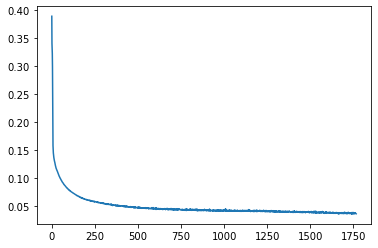

In [74]:
model, history = my_model(X_train[:400,:], y_train[:400,:], -10000, tf.optimizers.SGD(learning_rate=lr))

Epoch 1/100
787/787 [==============================] - 1s 710us/step - loss: 0.2065 - accuracy: 0.7055
Epoch 2/100
787/787 [==============================] - 1s 688us/step - loss: 0.1038 - accuracy: 0.8389
Epoch 3/100
787/787 [==============================] - 1s 718us/step - loss: 0.1027 - accuracy: 0.8454
Epoch 4/100
787/787 [==============================] - 1s 697us/step - loss: 0.1014 - accuracy: 0.8409
Epoch 5/100
787/787 [==============================] - 1s 688us/step - loss: 0.1032 - accuracy: 0.8378
Epoch 6/100
787/787 [==============================] - 1s 697us/step - loss: 0.1001 - accuracy: 0.8431
Epoch 7/100
787/787 [==============================] - 1s 693us/step - loss: 0.0998 - accuracy: 0.8473
Epoch 8/100
787/787 [==============================] - 1s 687us/step - loss: 0.0995 - accuracy: 0.8453
Epoch 9/100
787/787 [==============================] - 0s 626us/step - loss: 0.0977 - accuracy: 0.8476
Epoch 10/100
787/787 [==============================] - 0s 611us/step - l

787/787 [==============================] - 1s 693us/step - loss: 0.0976 - accuracy: 0.8505
Epoch 80/100
787/787 [==============================] - 1s 678us/step - loss: 0.0986 - accuracy: 0.8439
Epoch 81/100
787/787 [==============================] - 1s 704us/step - loss: 0.0995 - accuracy: 0.8463
Epoch 82/100
787/787 [==============================] - 1s 698us/step - loss: 0.0971 - accuracy: 0.8463
Epoch 83/100
787/787 [==============================] - 1s 680us/step - loss: 0.0998 - accuracy: 0.8440
Epoch 84/100
787/787 [==============================] - 1s 687us/step - loss: 0.0980 - accuracy: 0.8492
Epoch 85/100
787/787 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.85 - 1s 680us/step - loss: 0.0977 - accuracy: 0.8549
Epoch 86/100
787/787 [==============================] - 1s 681us/step - loss: 0.0974 - accuracy: 0.8529
Epoch 87/100
787/787 [==============================] - 1s 680us/step - loss: 0.0982 - accuracy: 0.8501
Epoch 88/100
787/787 [=============

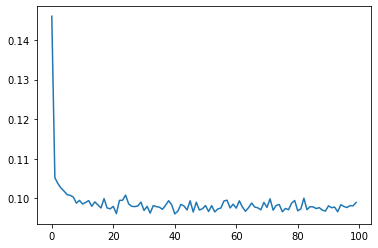

In [75]:
model, history = my_model(X_train, y_train, 100, tf.optimizers.Adam(learning_rate=0.01))

Epoch 1/100
787/787 [==============================] - 1s 700us/step - loss: 0.2275 - accuracy: 0.7110
Epoch 2/100
787/787 [==============================] - 1s 707us/step - loss: 0.1193 - accuracy: 0.8394
Epoch 3/100
787/787 [==============================] - 0s 636us/step - loss: 0.1081 - accuracy: 0.8414
Epoch 4/100
787/787 [==============================] - 0s 630us/step - loss: 0.0991 - accuracy: 0.8993
Epoch 5/100
787/787 [==============================] - 0s 621us/step - loss: 0.0951 - accuracy: 0.9173
Epoch 6/100
787/787 [==============================] - 0s 616us/step - loss: 0.0965 - accuracy: 0.9159
Epoch 7/100
787/787 [==============================] - 0s 626us/step - loss: 0.0928 - accuracy: 0.9220
Epoch 8/100
787/787 [==============================] - 0s 616us/step - loss: 0.0918 - accuracy: 0.9214
Epoch 9/100
787/787 [==============================] - 1s 652us/step - loss: 0.0932 - accuracy: 0.9194
Epoch 10/100
787/787 [==============================] - 1s 687us/step - l

787/787 [==============================] - 1s 679us/step - loss: 0.0898 - accuracy: 0.9247
Epoch 80/100
787/787 [==============================] - 1s 686us/step - loss: 0.0922 - accuracy: 0.9222
Epoch 81/100
787/787 [==============================] - 1s 697us/step - loss: 0.0900 - accuracy: 0.9252
Epoch 82/100
787/787 [==============================] - 1s 681us/step - loss: 0.0925 - accuracy: 0.9214
Epoch 83/100
787/787 [==============================] - 1s 702us/step - loss: 0.0902 - accuracy: 0.9236
Epoch 84/100
787/787 [==============================] - 1s 691us/step - loss: 0.0932 - accuracy: 0.9211
Epoch 85/100
787/787 [==============================] - 1s 683us/step - loss: 0.0917 - accuracy: 0.9224
Epoch 86/100
787/787 [==============================] - 1s 682us/step - loss: 0.0920 - accuracy: 0.9212
Epoch 87/100
787/787 [==============================] - 1s 677us/step - loss: 0.0928 - accuracy: 0.9194
Epoch 88/100
787/787 [==============================] - 1s 698us/step - loss:

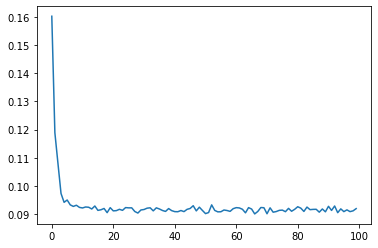

In [76]:
model, history = my_model(X_train, y_train, 100, tf.optimizers.Adam(learning_rate=0.005))

## ...No time for more try...

### Train accuracy:

In [77]:
history.history['accuracy'][-1]

0.9222239851951599

### Test accuracy:

In [78]:
results = model.evaluate(
    tf.convert_to_tensor(X_test, np.float32),
    tf.convert_to_tensor(y_test, np.float32), 
    batch_size=128)
print('test acc:', results[1])

97/97 [==============================] - 0s 623us/step - loss: 0.0633 - accuracy: 0.9426
test acc: 0.9426335096359253
